This notebook demonstrates how to do free space wave propagation in spherical coordinates. A Cartesian coordinate system is usually not suitable for the scenarios where the sample is placed close to a point source, as the phase ramp on the incident plane will be so high that it cannot be properly sampled with a finite-sized grid. By doing the job in a spherical coordinate system whose origin coincides with the point source, the problem can be solved easily.

Refer to this paper for more details and mathematical derivations:
Rubio, J. A., Belmonte, A. M., & Comeron, A. (1999). Numerical simulation of long-path spherical wave propagation in three-dimensional random media. Optical Engineering 38(09), 38(9), 1462. http://doi.org/10.1117/1.602198

In [62]:
import xdesign
import numpy as np
import matplotlib.pyplot as plt
from pyfftw.interfaces.numpy_fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
import dxchange
from tqdm import tqdm
%matplotlib inline

In [63]:
PI = 3.1415927

def gen_mesh(max, shape):
    """Generate mesh grid.
    """
    yy = np.linspace(-max[0], max[0], shape[0])
    xx = np.linspace(-max[1], max[1], shape[1])
    res = np.meshgrid(xx, yy)
    return res

def real_imag_to_mag_phase(realpart, imagpart):

    a = realpart + 1j * imagpart
    return np.abs(a), np.angle(a)

def mag_phase_to_real_imag(mag, phase):

    a = mag * np.exp(1j * phase)
    return a.real, a.imag

def plot_img(a):
    plt.figure()
    plt.imshow(a)
    plt.show()
    
def generate_disk(shape, radius, anti_aliasing=5):

    shape = np.array(shape)
    radius = int(radius)
    x = np.linspace(-radius, radius, (radius * 2 + 1) * anti_aliasing)
    y = np.linspace(-radius, radius, (radius * 2 + 1) * anti_aliasing)
    xx, yy = np.meshgrid(x, y)
    a = (xx**2 + yy**2 <= radius**2).astype('float')
    res = np.zeros(shape * anti_aliasing)
    center_res = (np.array(res.shape) / 2).astype('int')
    res[center_res[0] - int(a.shape[0] / 2):center_res[0] - int(a.shape[0] / 2) + a.shape[0],
        center_res[1] - int(a.shape[0] / 2):center_res[1] - int(a.shape[0] / 2) + a.shape[1]] = a
    res = gaussian_filter(res, 0.5 * anti_aliasing)
    res = res[::anti_aliasing, ::anti_aliasing]
    return res

def plot_mod_and_phase(arr, figsize=(12, 5), title=None, unwrap=False):
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(np.abs(arr))
    plt.title('Modulus')
    ax2 = fig.add_subplot(1, 2, 2)
    phase_term = np.angle(arr)
    if unwrap:
        phase_term = np.unwrap(phase_term)
    ax2.imshow(phase_term)
    plt.title('Phase')
    if title is not None:
        plt.suptitle(title)
    plt.show()

phi and theta are respectively the polar and azimuthal angle. The extent of wavefront is defined by the maximum angular extension of the spherical wave, with its source located at the origin.

In [64]:
phi_max = PI / 18
theta_max = PI / 18
probe_size = [256, 256]
energy_ev = 5000.
r_init_nm = 1000.
delta_r_nm = 1.
wavelen_nm = 1240. / energy_ev

Initialize wavefront according to sample-source distance.

In [65]:
def initialize_wavefront(r_init_nm, wavelen_nm, probe_size):
    phase_ang = r_init_nm % wavelen_nm / wavelen_nm * 2 * PI
    wavefront = np.zeros(probe_size, dtype=np.complex64)
    wavefront[...] = np.exp(1j * phase_ang)
    return wavefront

Define free space propagation function in spherical coordinates as in Rubio et al. (1999). 

In [66]:
# spherical array is organized as: [r, theta, phi].
def free_propagate_spherical(wavefront, dist_cm, r_cm, wavelen_nm):
    
    dist_nm = dist_cm * 1.e7
    r_nm = r_cm * 1.e7
    phi, theta = gen_mesh([theta_max, phi_max], probe_size)
    k_theta = PI / theta_max * (np.arange(probe_size[0]) - float(probe_size[0] - 1) / 2)
    k_phi = PI / phi_max * (np.arange(probe_size[1]) - float(probe_size[1] - 1) / 2)
    k_phi, k_theta = np.meshgrid(k_phi, k_theta)
    k = 2 * PI / wavelen_nm
    wavefront = fftshift(fft2(wavefront))
    wavefront *= np.exp(-1j / (2 * k) * (k_theta ** 2 + k_phi ** 2) * (1. / (r_nm + dist_nm) - 1. / r_nm))
    wavefront = ifft2(ifftshift(wavefront))
    return wavefront

Define modulation function.

In [67]:
def slice_modify(delta_slice, beta_slice, wavefront, delta_r_nm, wavelen_nm):
    """Modify wavefront within a slice.
    """
    kz = 2 * PI * delta_r_nm / wavelen_nm
    wavefront *= np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
    return wavefront

To test the algorithm, we begin with the simpliest case where the object is just a curved thin slice whose curvature is identical to that of the spherical wave.

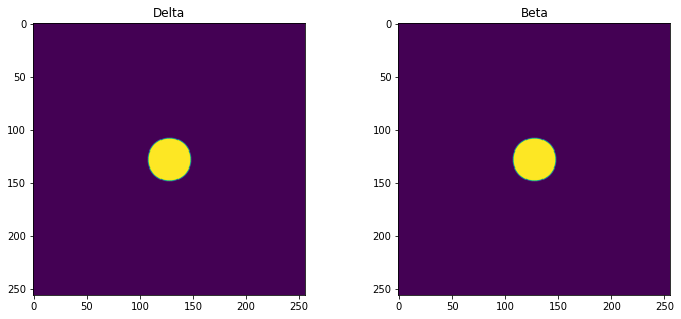

In [68]:
slice_size = 256
energy_ev = 5000
free_prop_dist_cm = 10
delta = 1.e-5
beta = 1.e-6
delta_slice = generate_disk([slice_size, slice_size], 20, anti_aliasing=5) * delta
beta_slice = generate_disk([slice_size, slice_size], 20, anti_aliasing=5) * beta
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(delta_slice)
plt.title('Delta')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(beta_slice)
plt.title('Beta')
plt.show()

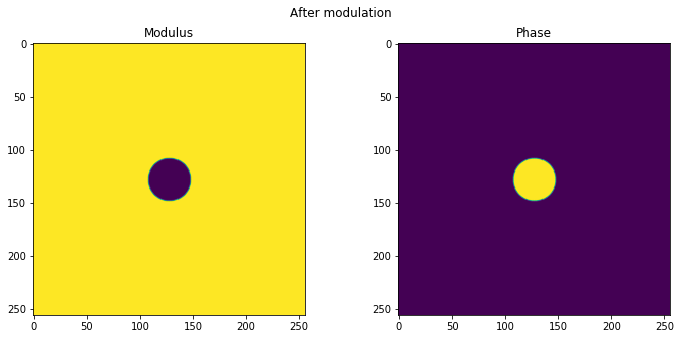

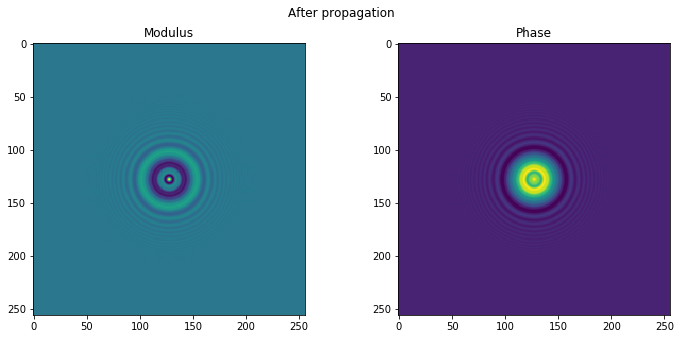

In [69]:
prop_dist_cm = 1.e-3
wavefront = initialize_wavefront(r_init_nm, wavelen_nm, probe_size)
wavefront = slice_modify(delta_slice, beta_slice, wavefront, delta_r_nm, wavelen_nm)
plot_mod_and_phase(wavefront, title='After modulation')
wavefront = free_propagate_spherical(wavefront, prop_dist_cm, r_init_nm * 1.e-7, wavelen_nm)
plot_mod_and_phase(wavefront, title='After propagation')

Now we try something big by propagating the wavefront through a 3D object that is originally defined in Cartesian coordinates.

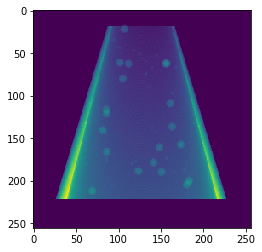

In [70]:
# read in object
grid_delta = np.load('phantom/grid_delta.npy')
grid_beta = np.load('phantom/grid_beta.npy')
# swap axis so that it is in [x, y, z] format
grid_delta = np.swapaxes(grid_delta, 0, 1)
grid_beta = np.swapaxes(grid_beta, 0, 1)
plot_img(np.sum(grid_delta, axis=0))

Define a function to convert the array from Cartesian grid to spherical grid organized in [r, theta, phi] format.


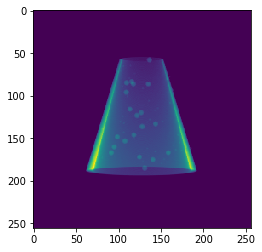

In [71]:
def cartesian_to_spherical(arr, dist_to_source_nm, psize_nm):
    
    x_ind, y_ind, z_ind = [np.arange(arr.shape[0], dtype=int), 
                           np.arange(arr.shape[1], dtype=int), 
                           np.arange(arr.shape[2], dtype=int)]
    x_true, y_true, z_true = [(x_ind - np.median(x_ind)) * psize_nm, 
                              (y_ind - np.median(y_ind)) * psize_nm, 
                              z_ind * psize_nm]
    cart_interp = RegularGridInterpolator((x_true, y_true, z_true), arr, bounds_error=False, fill_value=0)
    r_ind, theta_ind, phi_ind = [np.arange(arr.shape[0], dtype=int), 
                                 np.arange(arr.shape[1], dtype=int), 
                                 np.arange(arr.shape[2], dtype=int)]
    r_true = r_ind * psize_nm + dist_to_source_nm
    theta_true = (theta_ind - np.median(theta_ind)) * (2 * theta_max / (theta_ind.size - 1))
    phi_true = (phi_ind - np.median(phi_ind)) * (2 * phi_max / (phi_ind.size - 1))
    r, theta, phi = np.meshgrid(r_true, theta_true, phi_true)
    x_interp = r * np.cos(theta) * np.sin(phi)
    y_interp = r * np.sin(theta)
    z_interp = r * np.cos(theta) * np.cos(phi)
    z_interp -= dist_to_source_nm
    x_interp /= psize_nm
    y_interp /= psize_nm
    z_interp /= psize_nm
    coords_interp = np.vstack([x_interp.flatten(), y_interp.flatten(), z_interp.flatten()]).transpose()
    dat_interp = cart_interp(coords_interp)
    r_ind_mesh, theta_ind_mesh, phi_ind_mesh = np.meshgrid(r_ind, theta_ind, phi_ind)
    arr_sph = np.zeros_like(arr)
    arr_sph[r_ind_mesh.flatten(), theta_ind_mesh.flatten(), phi_ind_mesh.flatten()] = dat_interp
    
    return arr_sph, (r_true, theta_true, phi_true)

sph_delta, (r_true, theta_true, phi_true) = cartesian_to_spherical(grid_delta, r_init_nm, delta_r_nm)
sph_beta, (r_true, theta_true, phi_true) = cartesian_to_spherical(grid_beta, r_init_nm, delta_r_nm)
plot_img(np.sum(sph_delta, axis=0))

Now do multislice propagation using the transformed grid.

100%|██████████| 256/256 [00:01<00:00, 199.85it/s]


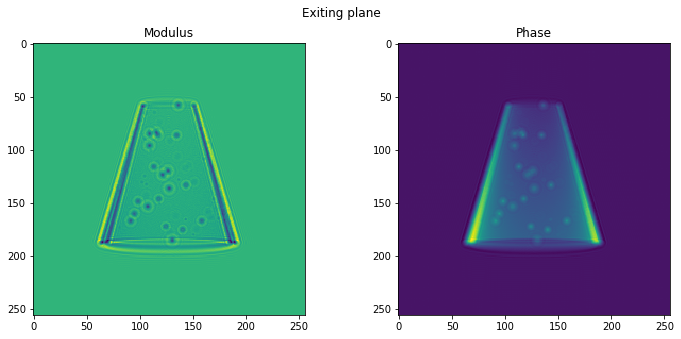

In [72]:
wavefront = initialize_wavefront(r_init_nm, wavelen_nm, probe_size)
for i_slice in tqdm(range(sph_delta.shape[0])):
    delta_slice = sph_delta[i_slice, :, :]
    beta_slice = sph_beta[i_slice, :, :]
    wavefront = slice_modify(delta_slice, beta_slice, wavefront, delta_r_nm, wavelen_nm)
    wavefront = free_propagate_spherical(wavefront, 
                                         delta_r_nm * 1e-7, 
                                         (r_init_nm + i_slice * delta_r_nm) * 1.e-7, 
                                         wavelen_nm)
plot_mod_and_phase(wavefront, title='Exiting plane')

We eventually need to know the wavefront at a planar detector downstream to the exiting plane. This is a window whose Cartesian coordinates have z = r_final and finite x and y extent. The strategy to convert the wavefront on a shell to a planar one is the following: first define the spatial extent of the detector, and calculate the spherical coordinates (r, theta, phi) from its cartesian coordinates (x, y, z). After we figure out the range of r, do a series of propagations to compute the wavefront on different r values, which yields a subspace in the spherical coordinates. Finally, interpolate the planar wavefront in this subspace. 

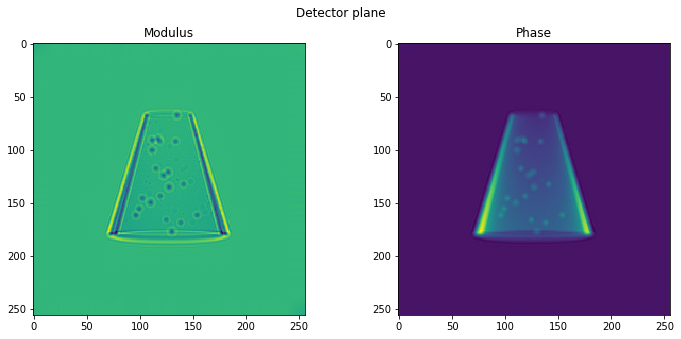

In [99]:
def get_wavefront_on_plane(wavefront_sph, r_nm, detector_size, delta_r_nm, psize_nm):
    
    x_ind, y_ind = [np.arange(detector_size[1], dtype=int),
                   np.arange(detector_size[0], dtype=int)]
    x_ind_mesh, y_ind_mesh = np.meshgrid(x_ind, y_ind)
    x_true = (x_ind - np.median(x_ind)) * psize_nm
    y_true = (y_ind - np.median(y_ind)) * psize_nm
    x_true_mesh, y_true_mesh = np.meshgrid(x_true, y_true)
    z_true = r_nm
    r_interp_mesh = np.sqrt(x_true_mesh ** 2 + y_true_mesh ** 2 + z_true ** 2) 
    theta_interp_mesh = -np.arccos(y_true_mesh / r_interp_mesh) + PI / 2
    phi_interp_mesh = np.arctan(x_true_mesh / z_true) 
    sph_wave_array = [wavefront_sph]
    r_current = r_nm
    while r_current < r_interp_mesh.max():
        r_current += delta_r_nm
        wavefront_sph = free_propagate_spherical(wavefront_sph, 
                                                 delta_r_nm * 1e-7, 
                                                 (r_current) * 1.e-7, 
                                                 wavelen_nm)
        sph_wave_array.append(wavefront_sph)
    sph_wave_array = np.array(sph_wave_array)
    r_ind, theta_ind, phi_ind = [np.arange(sph_wave_array.shape[0], dtype=int), 
                                 np.arange(sph_wave_array.shape[1], dtype=int), 
                                 np.arange(sph_wave_array.shape[2], dtype=int)]
    r_true = r_ind * delta_r_nm + r_nm
    theta_true = (theta_ind - np.median(theta_ind)) * (2 * theta_max / (theta_ind.size - 1))
    phi_true = (phi_ind - np.median(phi_ind)) * (2 * phi_max / (phi_ind.size - 1))
    sph_interp = RegularGridInterpolator((r_true, theta_true, phi_true), 
                                         sph_wave_array, bounds_error=False, fill_value=None)
    coords_interp = np.vstack([r_interp_mesh.flatten(), theta_interp_mesh.flatten(), 
                               phi_interp_mesh.flatten()]).transpose()
    dat_interp = sph_interp(coords_interp)
    wavefront_pla = dat_interp.reshape([256, 256])
    return wavefront_pla

wavefront_det = get_wavefront_on_plane(wavefront, 
                                       r_init_nm + delta_r_nm * sph_delta.shape[0], 
                                       probe_size, 
                                       delta_r_nm, 
                                       delta_r_nm * 2)
plot_mod_and_phase(wavefront_det, title='Detector plane')